## CRISPR screen analysis

In this notebook, we examined whether UPS driver genes may alter T cell mediated killing. Specifically, we examined a previous CRISPR co-culture screen of cancer cells with T cells that identified regulators of T-cell mediated killing (Pan et al., 2018).

In [2]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import utils

The first step is to read in the log fold changes for the sgRNA and to normalize them relative to the control sgRNAs.

In [3]:
# read in the sgRNA log fold change values
df = pd.read_csv('data/crispr/logFC.raw', sep='\t')
df = df.reset_index().rename(columns={'index': 'ID'})
df['gene'] = df['ID'].str.split('@', expand=True)[0].str.upper()

# the conditions of interest are Pmel and OT1 in Pan et al study
logFC_Pmel_P = df['Pmel-1_1st;IFNg+']-df['Pmel-1_1st;OT1_Ctrl_IFNg+']
logFC_OT1 = df['OT-1_1st;OVA-+']-df['OT-1_1st;OVA-']

# control guides ar emarked with "no_current"
median_OT1_ctrl = logFC_OT1[df['gene']=='NO_CURRENT'].median()
median_Pmel_ctrl = logFC_Pmel_P[df['gene']=='NO_CURRENT'].median()

# subtract out the control
df['OT1'] = logFC_OT1 - median_OT1_ctrl
df['Pmel'] = logFC_Pmel_P - median_Pmel_ctrl

# create gene scores
ot1 = df.groupby('gene')['OT1'].median()
pmel = df.groupby('gene')['Pmel'].median()
ot1_zscore = (ot1 - ot1.mean()) / ot1.std()
pmel_zscore = (pmel - pmel.mean()) / pmel.std()
crispr_scores = pd.DataFrame({
    'OT1': ot1,
    'Pmel': pmel,
    'OT1 zscore': ot1_zscore,
    'Pmel zscore': pmel_zscore
}).reset_index()

Here, we look at the relative depletion of guide RNAs for CUL3, which we find for most guid RNAs is depleted relatively depleted.

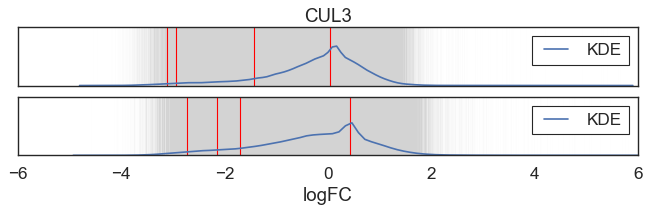

In [4]:
with sns.axes_style('white'), sns.plotting_context('notebook', font_scale=1.4):
    gene = 'CUL3'
    fig, axes = plt.subplots(2, 1, sharex=True)
    for i, cond in enumerate(['OT1', 'Pmel']):
        sns.rugplot(df[cond], height=1, color='lightgray', alpha=.02, ax=axes[i])
        sns.rugplot(df.loc[df['gene']==gene, cond], color='red', height=1, ax=axes[i])
        sns.kdeplot(df[cond], ax=axes[i], label='KDE')
        plt.xlim(-6, 6)
        axes[i].get_yaxis().set_visible(False)
    fig.set_size_inches(10, 2)
    plt.xlabel('logFC')
    axes[0].set_title(gene)

We next combine the results for both the OT1 and pmel condition by using Stouffer's z-score method.

In [6]:
crispr_scores['relative sgRNA abundance (zscore)'] = (crispr_scores['OT1 zscore'] + crispr_scores['Pmel zscore']) / np.sqrt(2)
crispr_scores['meta pvalue'] = 2*stats.norm.sf(np.abs(crispr_scores['relative sgRNA abundance (zscore)']))
crispr_scores['meta rank'] = crispr_scores['relative sgRNA abundance (zscore)'].rank()

With the combined results, we now plot the overall z-score for each of 11 UPS genes which had significant correlation with immune-related markers.

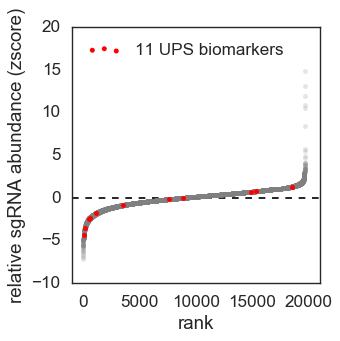

In [7]:
with sns.axes_style('white'), sns.plotting_context('notebook', font_scale=1.4):
    plt.axhline(0, linestyle='--', color='black', zorder=-5)
    sns.scatterplot('meta rank', 'relative sgRNA abundance (zscore)', data=crispr_scores, 
                    color='gray', edgecolors='red', linewidth=0, alpha=.2)
    immune_corr_hits = ['EP300', 'KMT2A', 'BRCA1', 'MAP3K1', 'USP9X', "CUL3", 'FBXW7', 'BAP1', 'VHL',
                        'KEAP1', 'SPOP']
    sns.scatterplot('meta rank', 'relative sgRNA abundance (zscore)', data=crispr_scores[crispr_scores['gene'].isin(immune_corr_hits)], 
                        color='red', edgecolors='black', linewidth=0, label='11 UPS biomarkers')
    plt.xlabel('rank')
    plt.xlim(-1000, 21000)
    plt.legend(loc='upper left', frameon=False)
    plt.gcf().set_size_inches(4,4)
    plt.savefig('figures/pan_et_al_gene_scores.pdf')